In [1]:
from benchmark import get_cath
from pathlib import Path

#change this
PATH_TO_PDB = Path('/scratch/datasets/pdb/')

#change this - not a problem if missing, should download a new one by default
cath_location = Path('/scratch/sequence-recovery-benchmark/cath-domain-description-file.txt')

cath_df = get_cath.read_data(cath_location)
new_df = get_cath.filter_with_user_list(cath_df,'/scratch/sequence-recovery-benchmark/dataset_visualization/crystal_structure_set.txt')
new_df = get_cath.append_sequence(new_df,PATH_TO_PDB)


/home/s1622572/anaconda3/envs/benchmark/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [2]:
new_df['resolution'] = get_cath.get_resolution(new_df, PATH_TO_PDB)

In [3]:
#useful functions, maybe add to the benchmark
def get_class_metric(df,metric):
    results=[]
    std=[]
    res_corr=[]
    df['metric']=metric
    results.append(df.metric.mean())
    std.append(df.metric.std())
    res_corr.append(np.corrcoef(df.resolution,df.metric)[0][1])
    
    results.append(df[df['class']==1].metric.mean())
    std.append(df[df['class']==1].metric.std())
    res_corr.append(np.corrcoef(df[df['class']==1].resolution,df[df['class']==1].metric)[0][1])
    
    results.append(df[df['class']==2].metric.mean())
    std.append(df[df['class']==2].metric.std())
    res_corr.append(np.corrcoef(df[df['class']==2].resolution,df[df['class']==2].metric)[0][1])

    
    results.append(df[df['class']==3].metric.mean())
    std.append(df[df['class']==3].metric.std())
    res_corr.append(np.corrcoef(df[df['class']==3].resolution,df[df['class']==3].metric)[0][1])

    results.append(df[(df['class']==4) | (df['class']==6)].metric.mean())
    std.append(df[(df['class']==4) | (df['class']==6)].metric.std())
    res_corr.append(np.corrcoef(df[(df['class']==4) | (df['class']==6)].resolution,df[(df['class']==4) | (df['class']==6)].metric)[0][1])

    
    return results,std,res_corr

#already in benchmark but not as a standalone function, also useful
def similarity_score(df,prediction_dict):
    similarity=[]
    for i,x in df.iterrows():
        sequence=x['sequence']
        most_likely_seq=list(get_cath.most_likely_sequence(prediction_dict[x.PDB+x.chain]))
        len(sequence)==len(most_likely_seq)
        similarity_score = [1 if get_cath.lookup_blosum62(a, b) > 0 else 0 for a, b in zip(sequence, most_likely_seq)]
        similarity.append(sum(similarity_score) / len(similarity_score))
    return similarity


In [4]:
models=['proteinsolver.csv','evoEF2.csv','prodconn.csv','rosetta.csv','timed.csv', 'densecpd.csv', 'timed_deep.csv', 'timed_rotamer.csv']
data={}
for x in models:
    print(x)
    #change this to where you keep .csv and .txt files.
    path_to_file=Path("performance_2022/"+x)
    
    predictions = get_cath.load_prediction_matrix(new_df, path_to_file.with_suffix('.txt'), path_to_file)
    accuracy,recall=get_cath.score_each(new_df,predictions,by_fragment=False)
    similarity=similarity_score(new_df,predictions)
    data[x]=[accuracy,recall,similarity]

proteinsolver.csv
evoEF2.csv
prodconn.csv
rosetta.csv
timed.csv
densecpd.csv
timed_deep.csv
timed_rotamer.csv


No handles with labels found to put in legend.


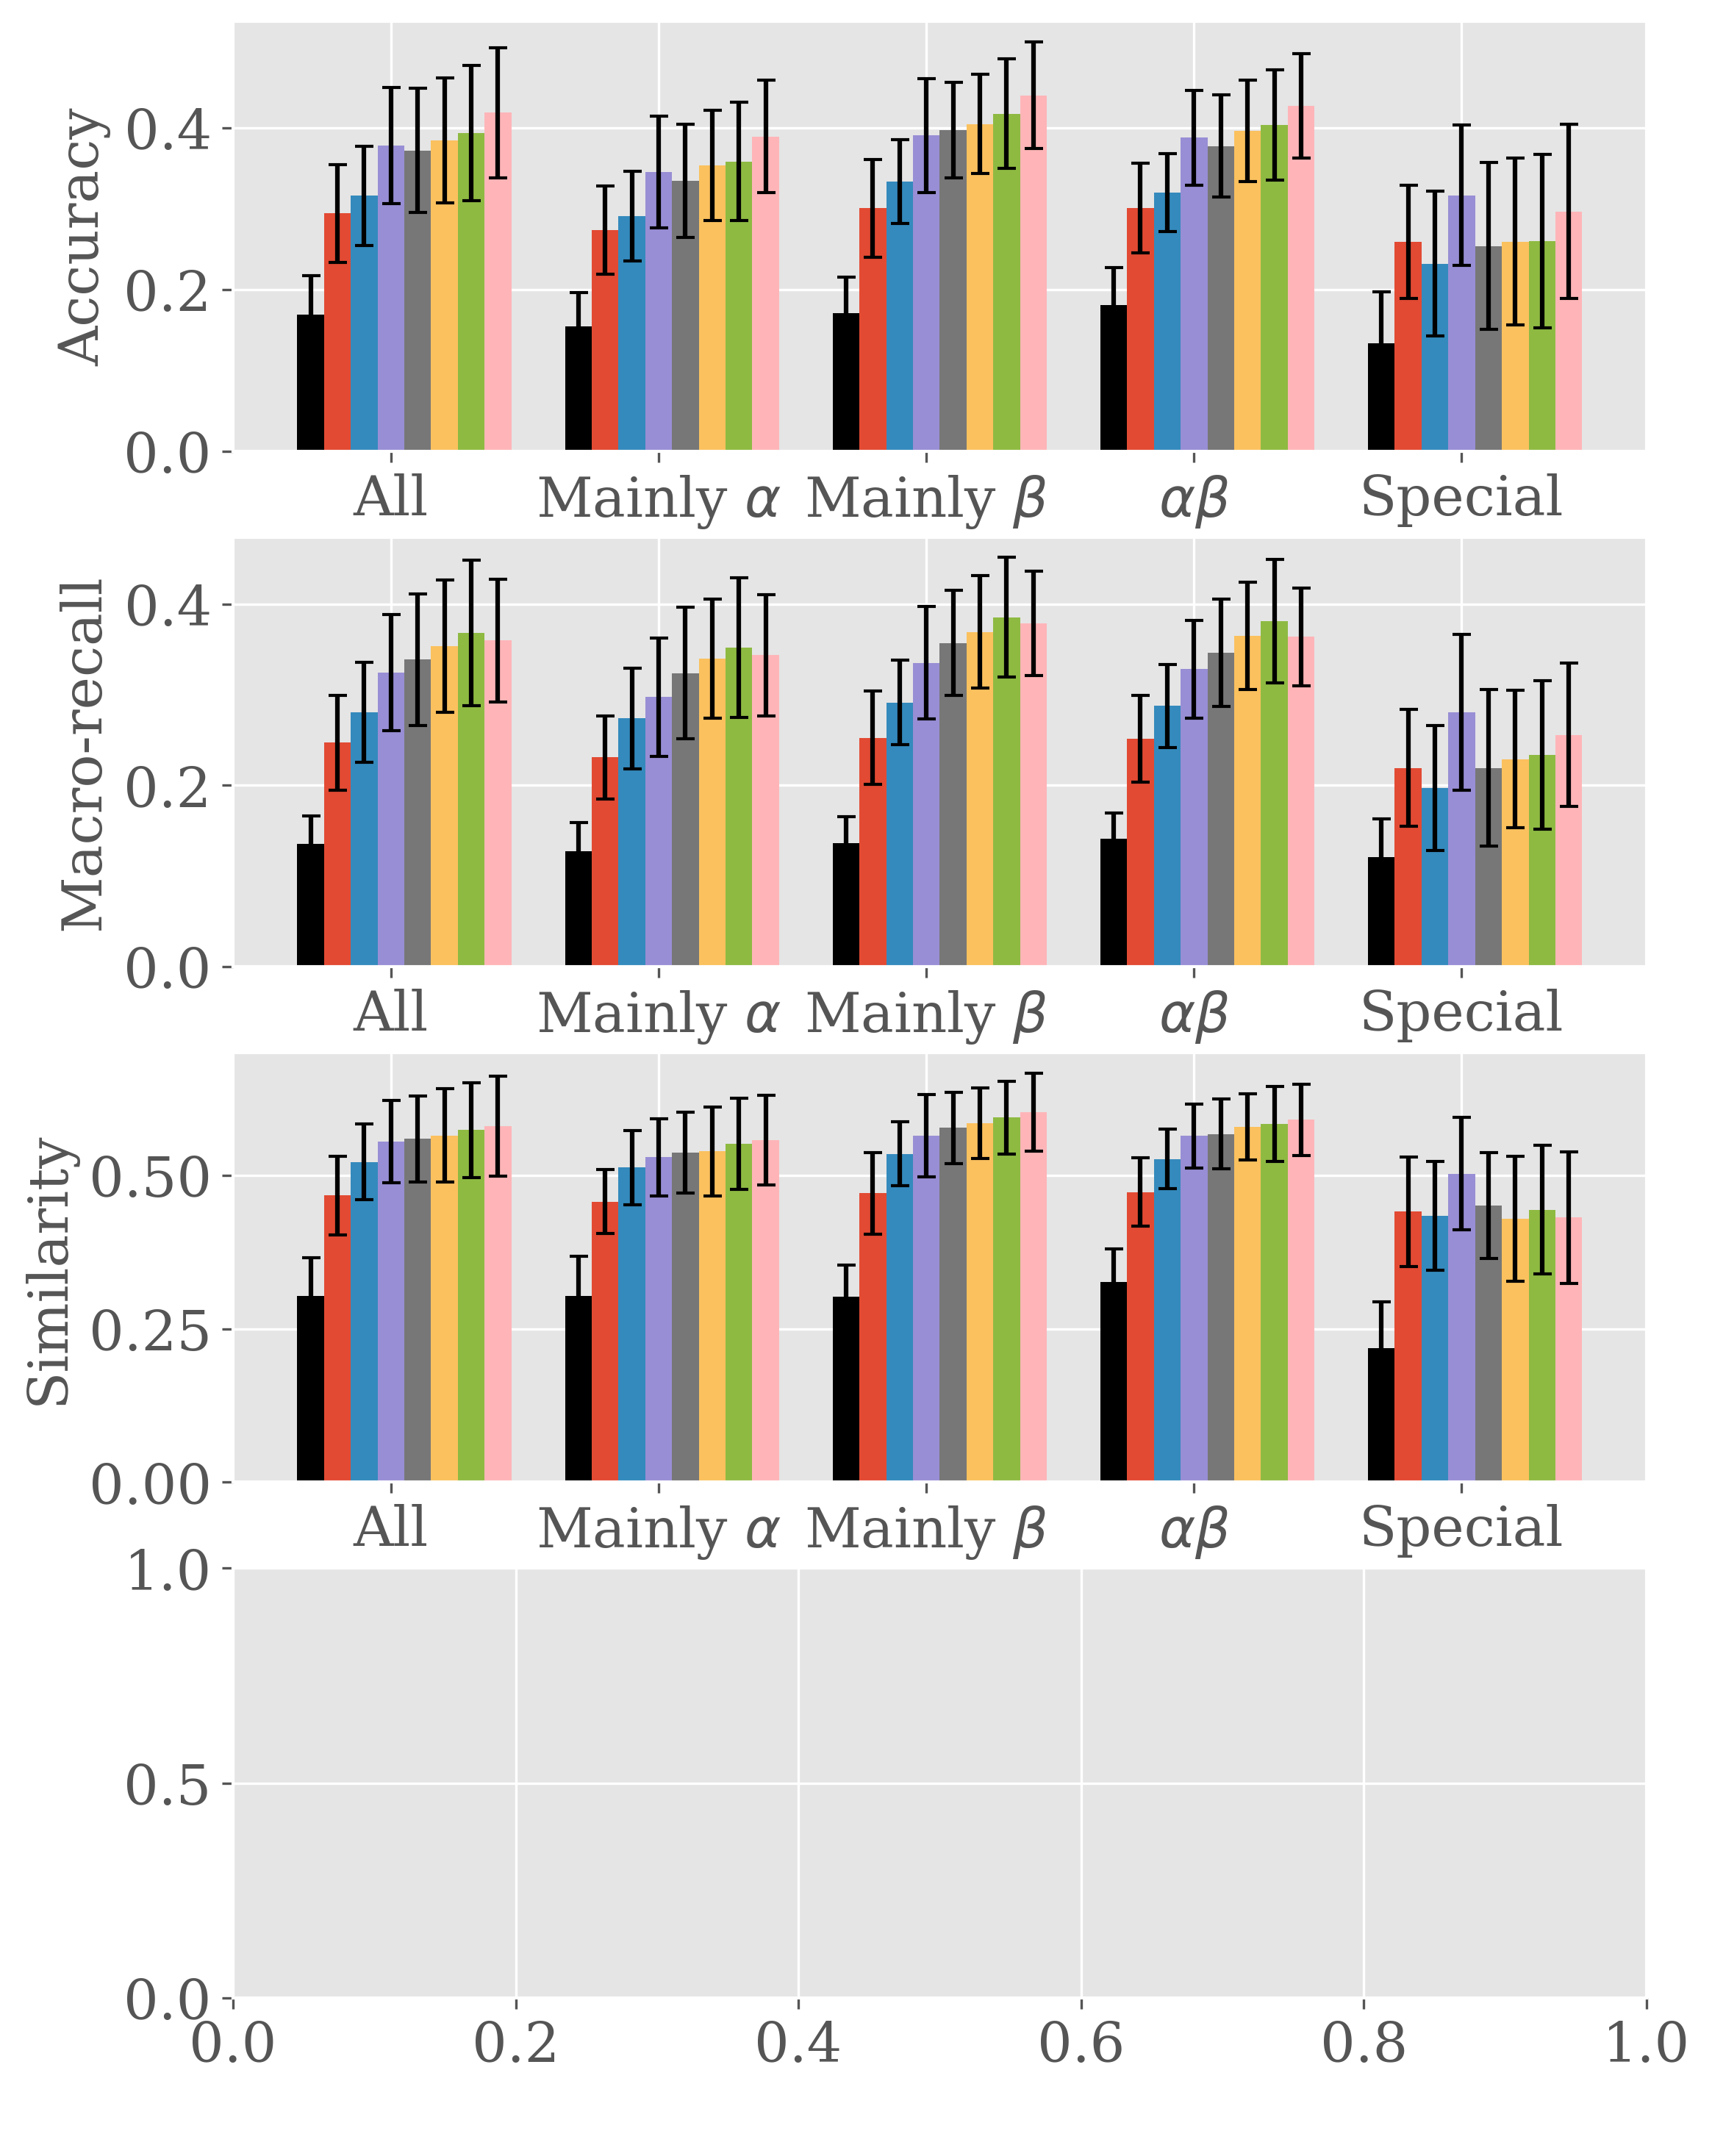

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
mpl.rc("savefig", dpi=300)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({'font.size': 18})
import numpy as np
colors=['k']+sns.color_palette()
legend=['ProteinSolver','EvoEF2','ProDCoNN','Rosetta','TIMED', 'DenseCPD', 'TIMED_deep', 'TIMED_rotamer']
fig,ax=plt.subplots(4,1,figsize=(8.27, 11.87), dpi=300)
k=np.arange(5)
for i,x in enumerate(data):
    acc,std,_=get_class_metric(new_df,data[x][0])
    ax[0].bar(x=k+i*0.1,height=acc,width=0.1,label=legend[i],color=colors[i])
    ax[0].errorbar(x=k+i*0.1,y=acc,yerr=std,fmt='none',c='black',capsize=3)
    rec,std,corr=get_class_metric(new_df,data[x][1])
    ax[1].bar(x=k+i*0.1,height=rec,width=0.1,label=legend[i],color=colors[i])
    ax[1].errorbar(x=k+i*0.1,y=rec,yerr=std,fmt='none',c='black',capsize=3)
    sim,std,_=get_class_metric(new_df,data[x][2])
    ax[2].bar(x=k+i*0.1,height=sim,width=0.1,label=legend[i],color=colors[i])
    ax[2].errorbar(x=k+i*0.1,y=sim,yerr=std,fmt='none',c='black',capsize=3)
    ax[0].set_ylabel('Accuracy',fontdict={"horizontalalignment": "center", "size": 18})
    ax[1].set_ylabel('Macro-recall',fontdict={"horizontalalignment": "center", "size": 18})
    ax[2].set_ylabel('Similarity',fontdict={"horizontalalignment": "center", "size": 18})
    ax[0].set_xticks(k+0.3)
    ax[0].set_xticklabels(['All',r'Mainly $\alpha $',r'Mainly $\beta $',r'$\alpha\beta $','Special'],)
    ax[1].set_xticks(k+0.3)
    ax[1].set_xticklabels(['All',r'Mainly $\alpha $',r'Mainly $\beta $',r'$\alpha\beta $','Special'])
    ax[2].set_xticks(k+0.3)
    ax[2].set_xticklabels(['All',r'Mainly $\alpha $',r'Mainly $\beta $',r'$\alpha\beta $','Special'])
    
    #remove ax[3] if you don't near correlation.
    #exclude proteinsolver
#     if i!=0:
#         ax[3].bar(x=k+i*0.1,height=-1*np.array(corr),width=0.1,label=legend[i],color=colors[i])
#         ax[3].set_ylabel('-Pearson correlation',fontdict={"horizontalalignment": "center", "size": 18})
#         ax[3].set_xticks(np.array([0,1,2,3,4])+0.3)
#         ax[3].set_xticklabels(['All',r'Mainly $\alpha $',r'Mainly $\beta $',r'$\alpha\beta $','Special'])
    
    
    
    

#ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg = plt.legend(ncol=len(legend), framealpha=1, frameon=False, bbox_to_anchor=(0.5, -0.15))


def export_legend(legend, filename="legend_small.pdf", expand=[-5, -5, 5, 5]):
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=300, bbox_inches=bbox)


export_legend(leg)
#plt.tight_layout()
plt.savefig('metrics_plot_12.pdf',dpi=600)

In [6]:
data['rosetta.csv']

[[0.33098591549295775,
  0.22727272727272727,
  0.2694300518134715,
  0.3458149779735683,
  0.28225806451612906,
  0.32706766917293234,
  0.391304347826087,
  0.5309278350515464,
  0.325,
  0.3488372093023256,
  0.3390804597701149,
  0.41379310344827586,
  0.4431818181818182,
  0.3815789473684211,
  0.2185430463576159,
  0.2864321608040201,
  0.27906976744186046,
  0.5297029702970297,
  0.4823529411764706,
  0.232,
  0.32847682119205296,
  0.3737864077669903,
  0.23300970873786409,
  0.34444444444444444,
  0.23529411764705882,
  0.3176470588235294,
  0.37333333333333335,
  0.2891566265060241,
  0.32989690721649484,
  0.350210970464135,
  0.30734966592427615,
  0.3584905660377358,
  0.2534722222222222,
  0.3117782909930716,
  0.3050647820965842,
  0.2777777777777778,
  0.26961770623742454,
  0.3233082706766917,
  0.3568281938325991,
  0.22998296422487224,
  0.2893081761006289,
  0.3181818181818182,
  0.24401913875598086,
  0.391025641025641,
  0.32677165354330706,
  0.38461538461538464,